# Kaggle TGS salt interpretation

## Background (Copied from TGS Salt Challenge page)

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.



In [1]:
%matplotlib inline

import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from tqdm import tqdm_notebook #, tnrange

from sklearn.model_selection import StratifiedKFold

from skimage.io import imread
from skimage.transform import resize
from skimage.morphology import label

import time
t_start = time.time()

## Input data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

In [2]:
# data directory
data_dir = '../../input'

### Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Loading a test DataFrame too with entries from depth not in train.

In [3]:
# Loading of training/testing ids and depths
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"), index_col="id", usecols=[0])
depths_df = pd.read_csv(os.path.join(data_dir, "depths.csv"), index_col="id")

In [4]:
train_df.head(3)

Empty DataFrame
Columns: []
Index: [575d24d81d, a266a2a9df, 75efad62c1]

In [5]:
depths_df.head(3)

z
id             
4ac19fb269  306
1825fadf99  157
f59821d067  305

In [6]:
train_df = train_df.join(depths_df)
train_df.head(3)

z
id             
575d24d81d  843
a266a2a9df  794
75efad62c1  468

In [7]:
# z ids for training data
train_z_df = depths_df[depths_df.index.isin(train_df.index)]

# z ids for test data
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [8]:
# qc the data
print(f" The total number of images: {len(depths_df)}")
print(f" The number of trained images: {len(train_df)}")
print(f" The number of test images: {len(test_df)}")

 The total number of images: 22000
 The number of trained images: 4000
 The number of test images: 18000


### Load images and their corresponding masks
load the images and masks into the DataFrame.

In [9]:
train_df["images"] = [imread(os.path.join(data_dir, "train/images/{}.png".format(idx))) for idx in tqdm_notebook(train_df.index)]

In [10]:
train_df["masks"] = [imread(os.path.join(data_dir, "train/masks/{}.png".format(idx)) ) for idx in tqdm_notebook(train_df.index)]

# reset salt id, i.e., from 255 or 65535 to 1
for mask in train_df["masks"]:
    mask[mask>0] = 1

### Data visualization codes

https://www.kaggle.com/kenmatsu4/basic-data-confirmation-visualization


(101, 101, 3) (101, 101)
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


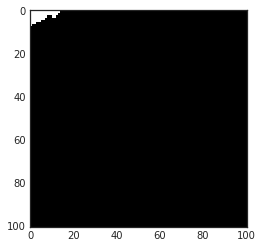

In [11]:
print(train_df["images"][0].shape, train_df["masks"][0].shape)

print(train_df["masks"][2])
plt.imshow(train_df["masks"][2], cmap="Greys")


## Histogram of depths

Text(0.5,1,'Histgram of depth')

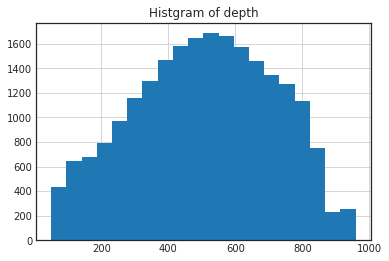

In [12]:
# total data
depths_df.z.hist(bins=20)
plt.title("Histgram of depth")

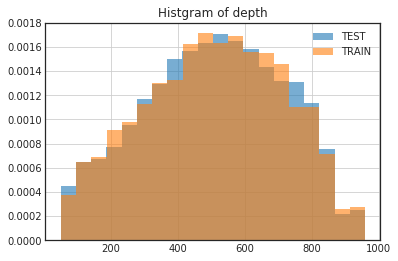

In [13]:
# test/train
bins = 20
alpha = 0.6
depths_df.loc[test_df.index].z.hist(bins=bins, alpha=alpha, density=True, label='TEST')
depths_df.loc[train_df.index].z.hist(bins=bins, alpha=alpha, density=True, label='TRAIN')
plt.title("Histgram of depth")
plt.legend(loc="best")

In [14]:
def draw_train_data(train_ids, start_pos=0, n_col = 5, n_row = 10, 
                    font_size=10, mask_thresh_lower=0, mask_thresh_upper=1):
    
    # starting position
    train_ids = train_ids[start_pos:]
    train_images = train_df["images"][start_pos:]
    train_masks = train_df["masks"][start_pos:]

    plt.figure(figsize=(16, 3.5*n_row))

    # total number of images
    n_img = n_col * n_row
    
    cnt = 0
    for i, img_id in enumerate(train_ids):

        # mask
        mask = train_masks[i]
        mask_ratio  = mask.sum()/np.prod(mask.shape)

        # check range of mask ratio
        if mask_ratio <= mask_thresh_lower or mask_thresh_upper < mask_ratio:
            continue
        
        # image
        image = train_images[i]

        # overlay image and mask
        plt.subplot(n_row, n_col, cnt+1)
        plt.imshow(image.mean(axis=2), cmap="Spectral")
        plt.imshow(mask, cmap="Greys", alpha=0.4)
        
        color_depth = image.sum()/np.prod(image.shape)
        depth = depths_df.loc[img_id].z
        plt.title("ID:{0}, depth={1}, ratio={2:0.1f}%".format(img_id, depth, mask_ratio*100), fontsize=font_size)

        plt.grid(False)
        plt.axis('off')
        
        if cnt+1 >= n_img:
            break
        cnt += 1

    #plt.tight_layout()
    plt.subplots_adjust(top=1.0, bottom=0.0, 
                        left=0.0, right=1.0, 
                        hspace=0.1, wspace=0.05)

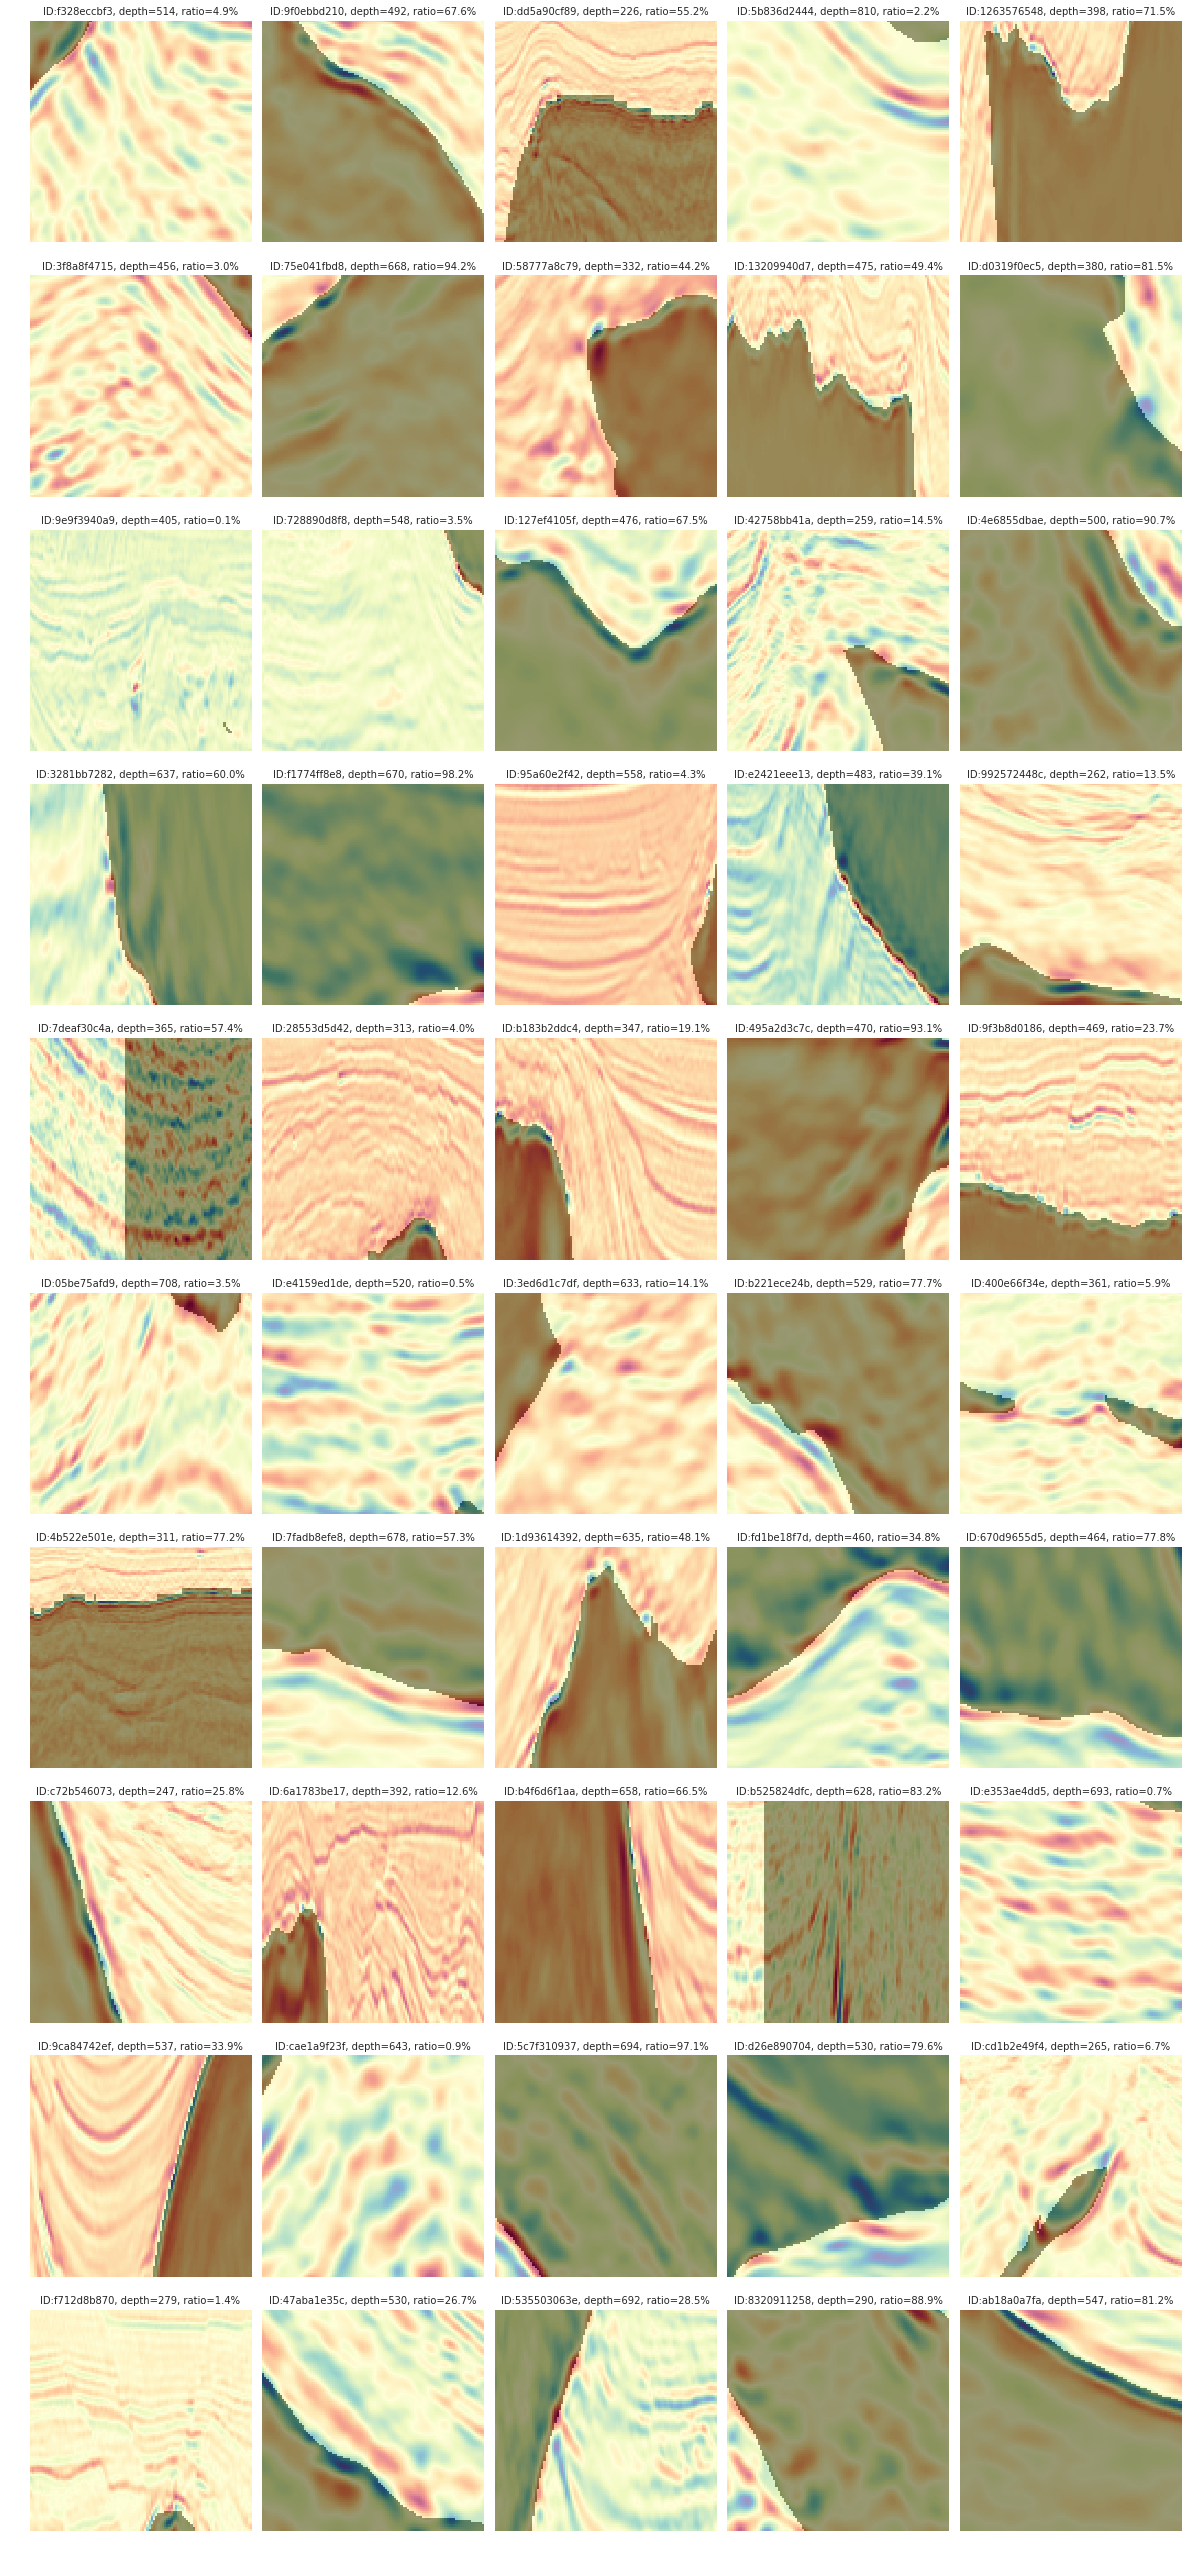

In [15]:
# checking some data
start_pos=50
# mask ratio: [0.0, 1.0)
draw_train_data(train_df.index, start_pos)

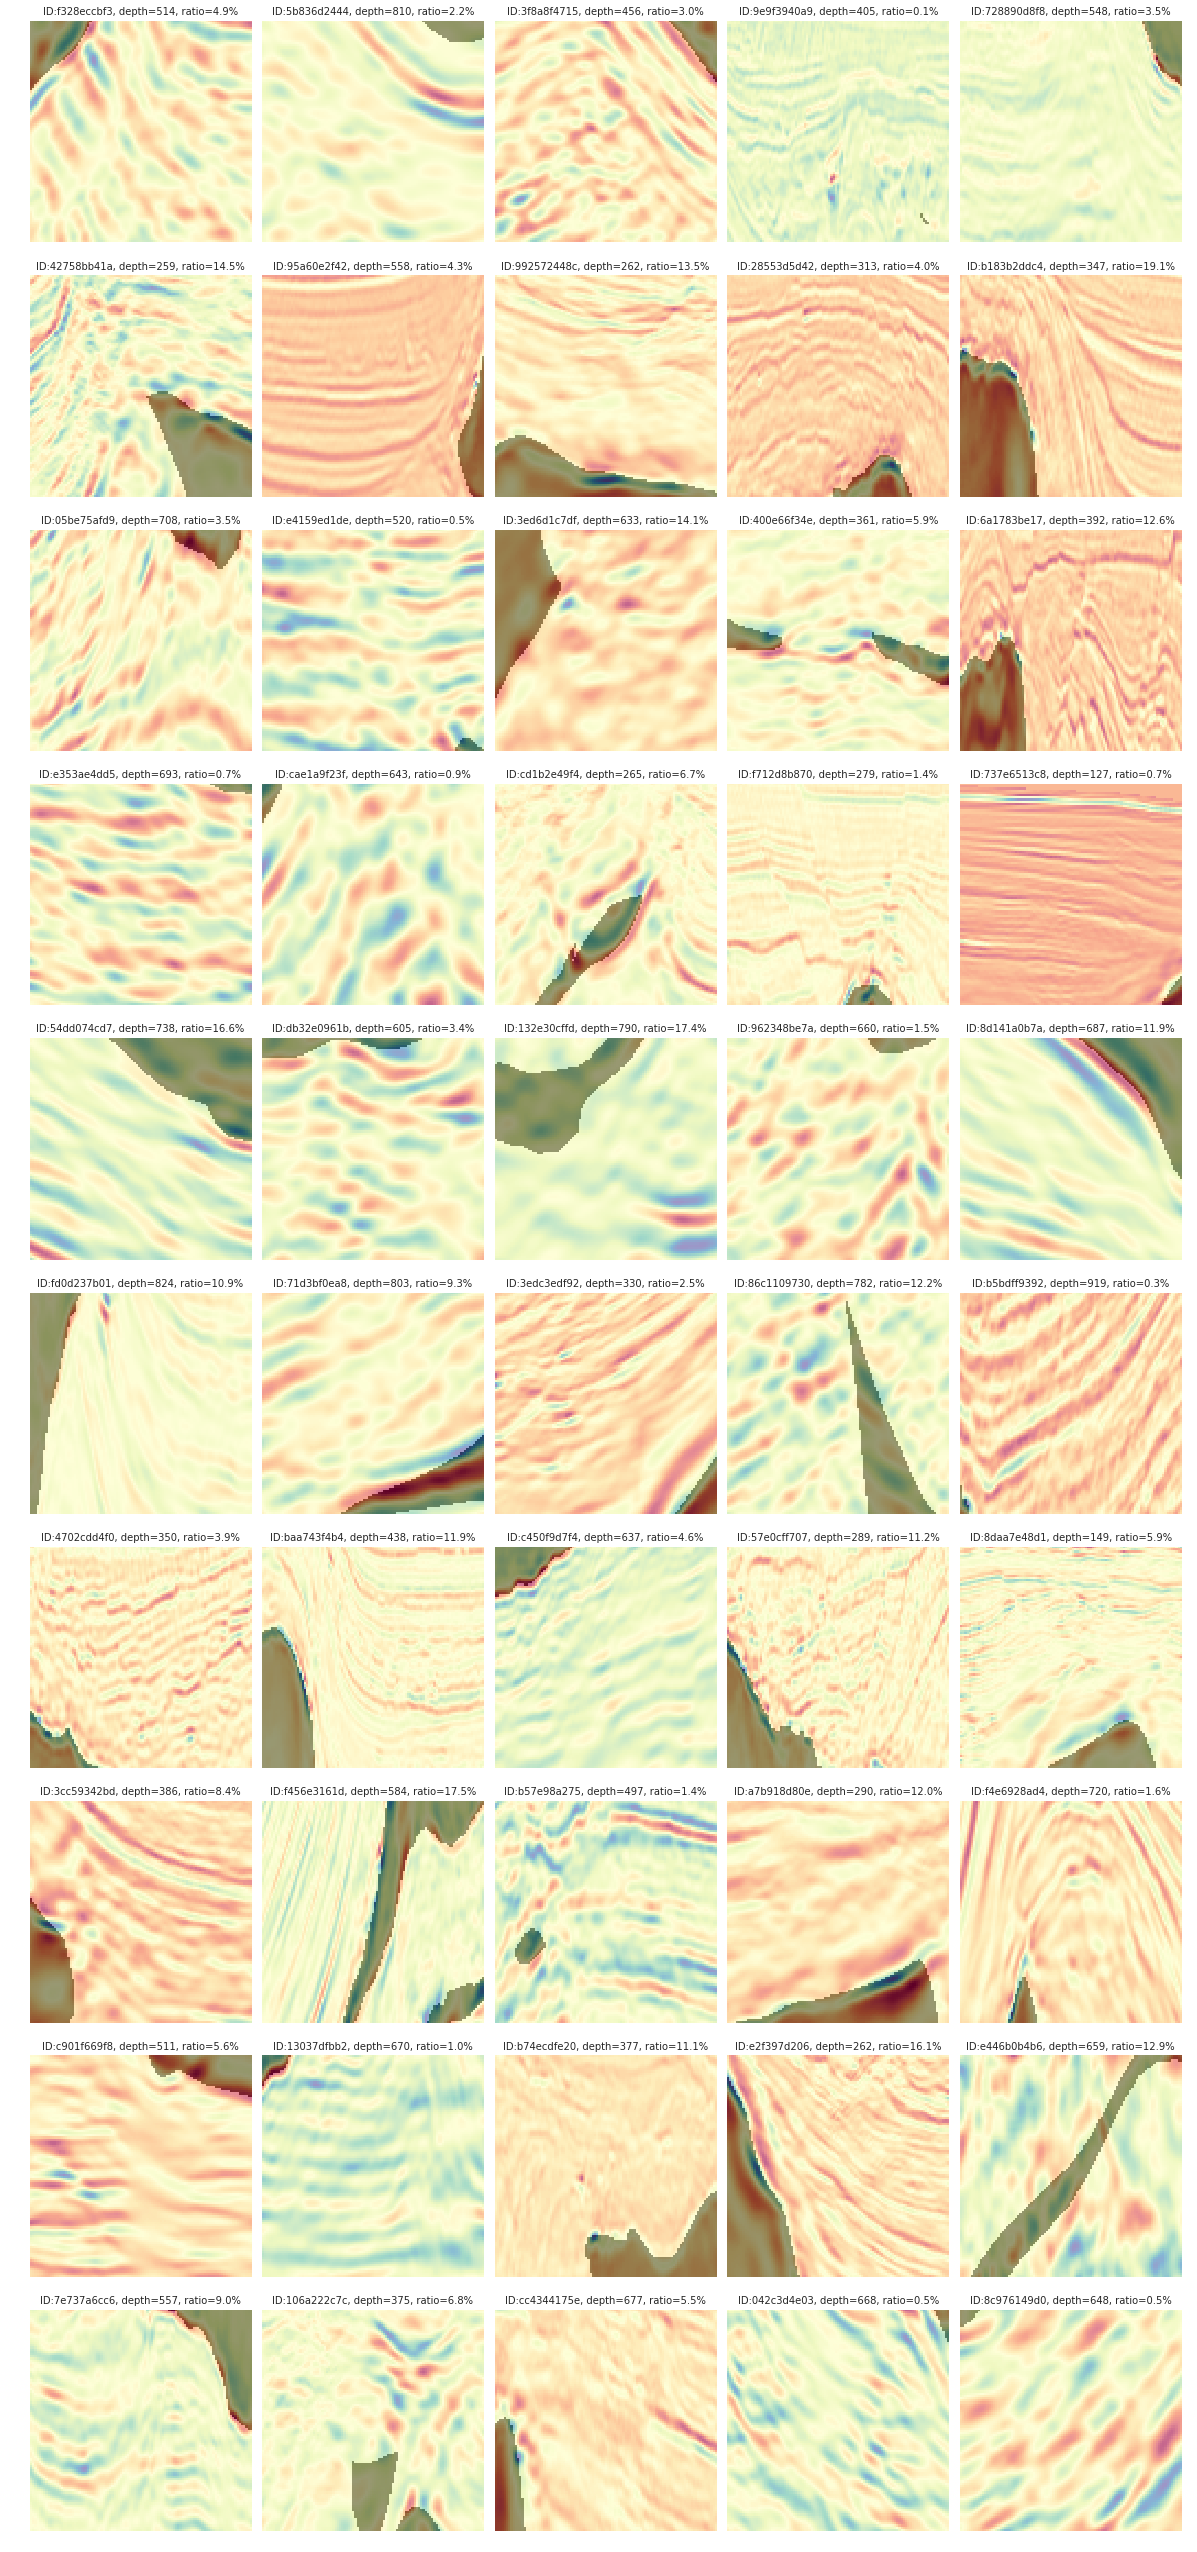

In [16]:
# mask ration: [0.0001, 0.2)
draw_train_data(train_df.index, start_pos, mask_thresh_lower=0.0001, mask_thresh_upper=0.2)

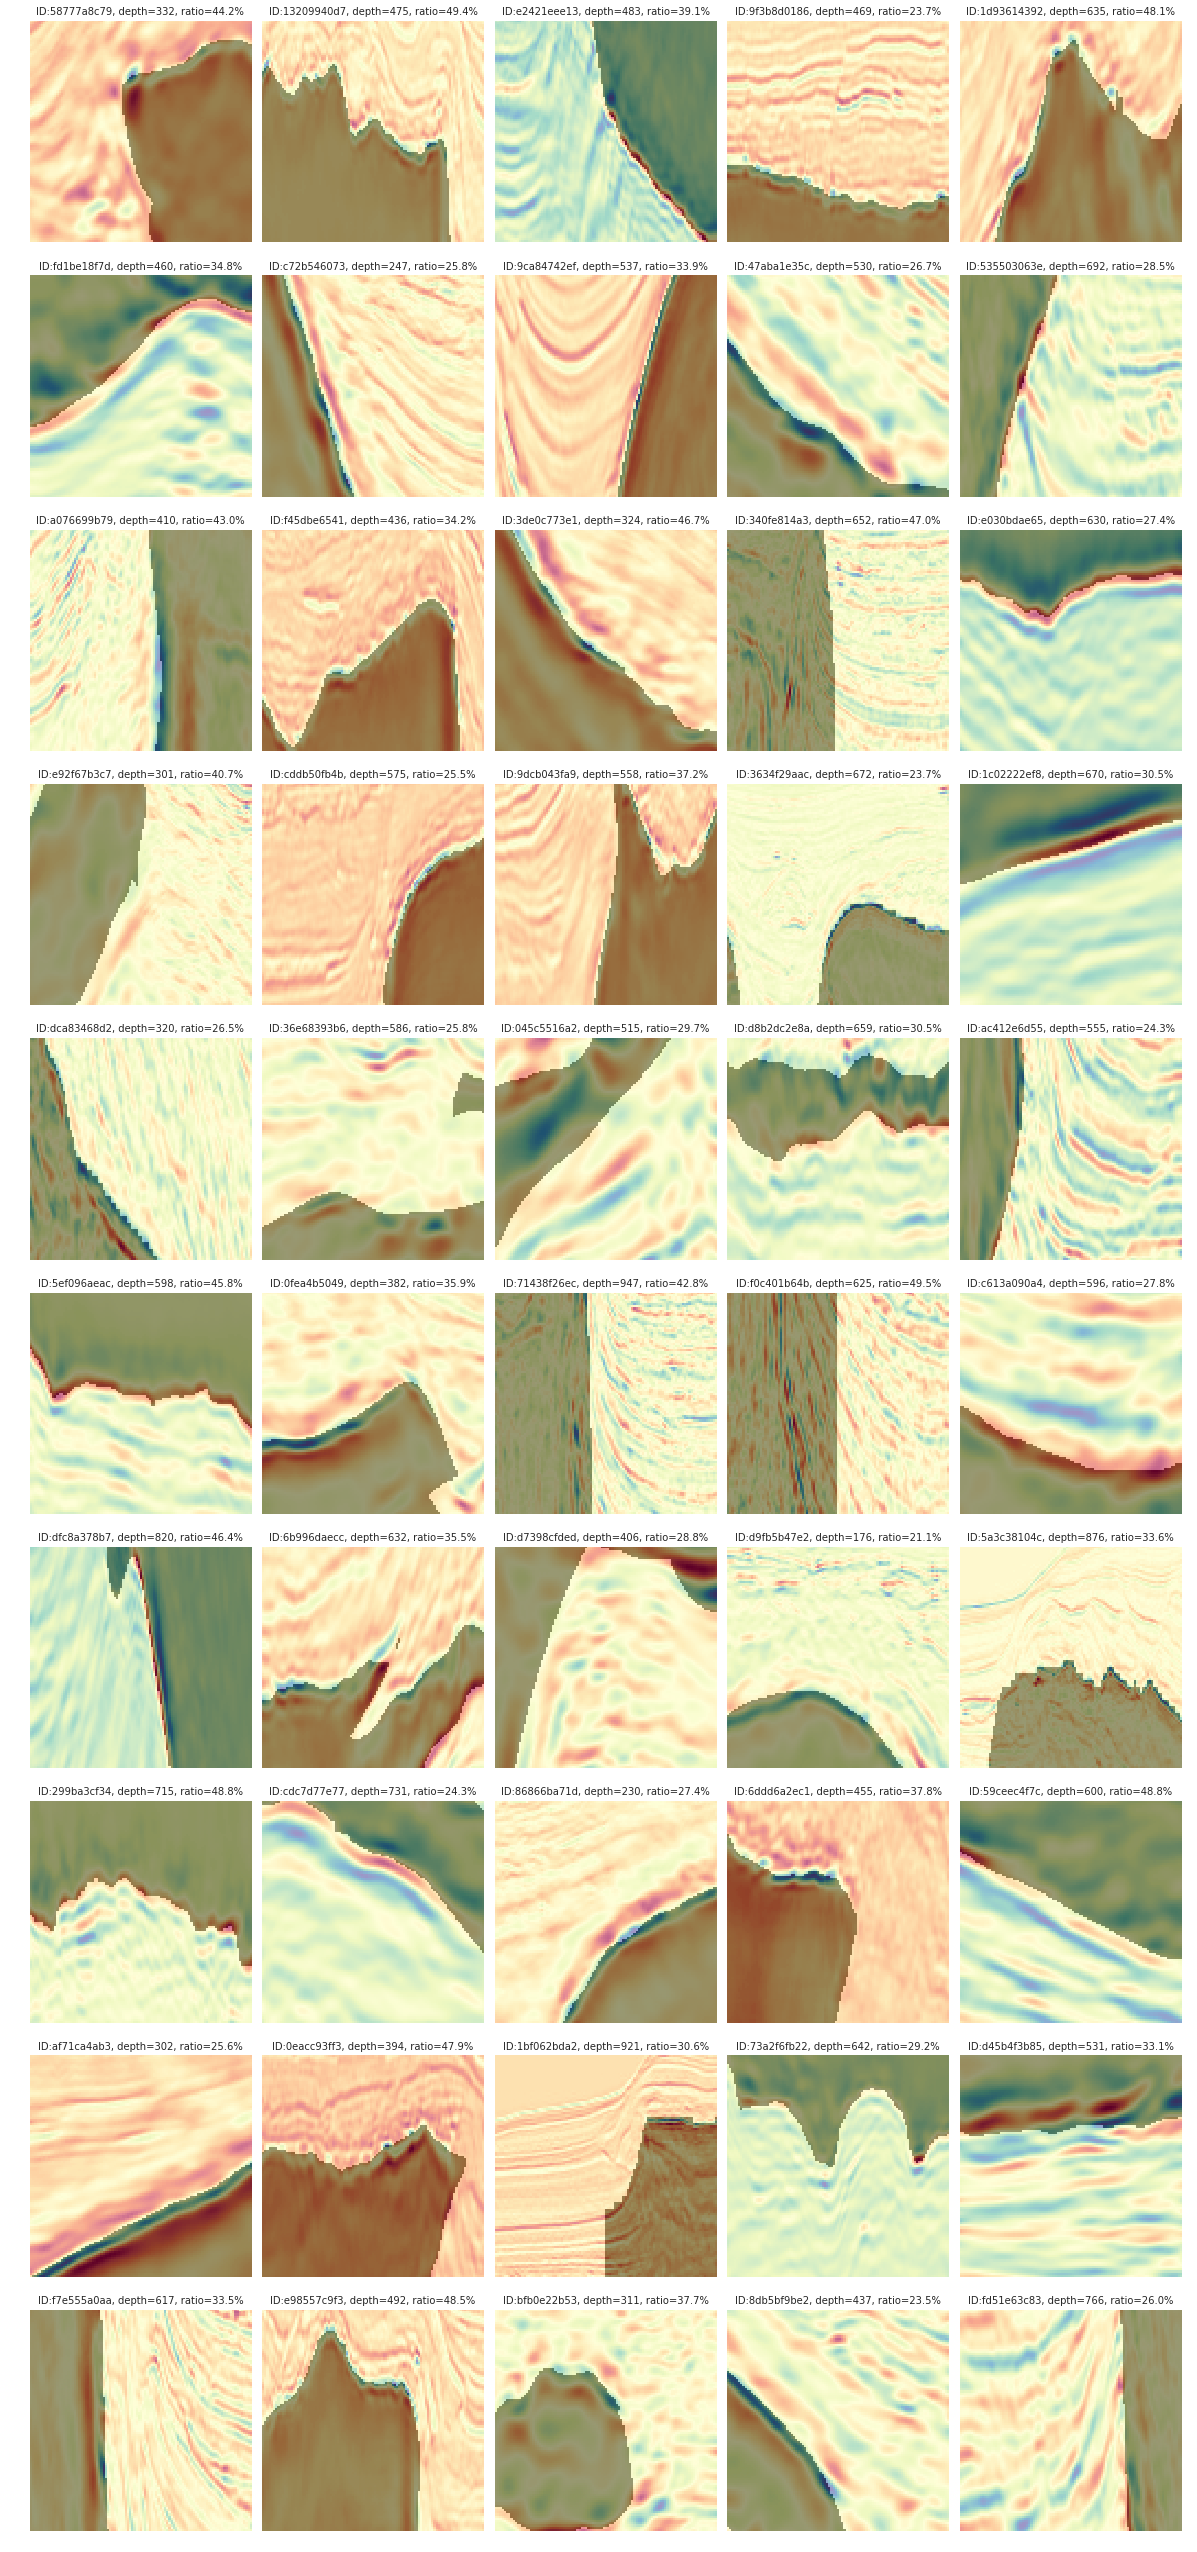

In [17]:
# mask ratio: [0.2, 0.5)
draw_train_data(train_df.index, start_pos, mask_thresh_lower=0.2, mask_thresh_upper=0.5)

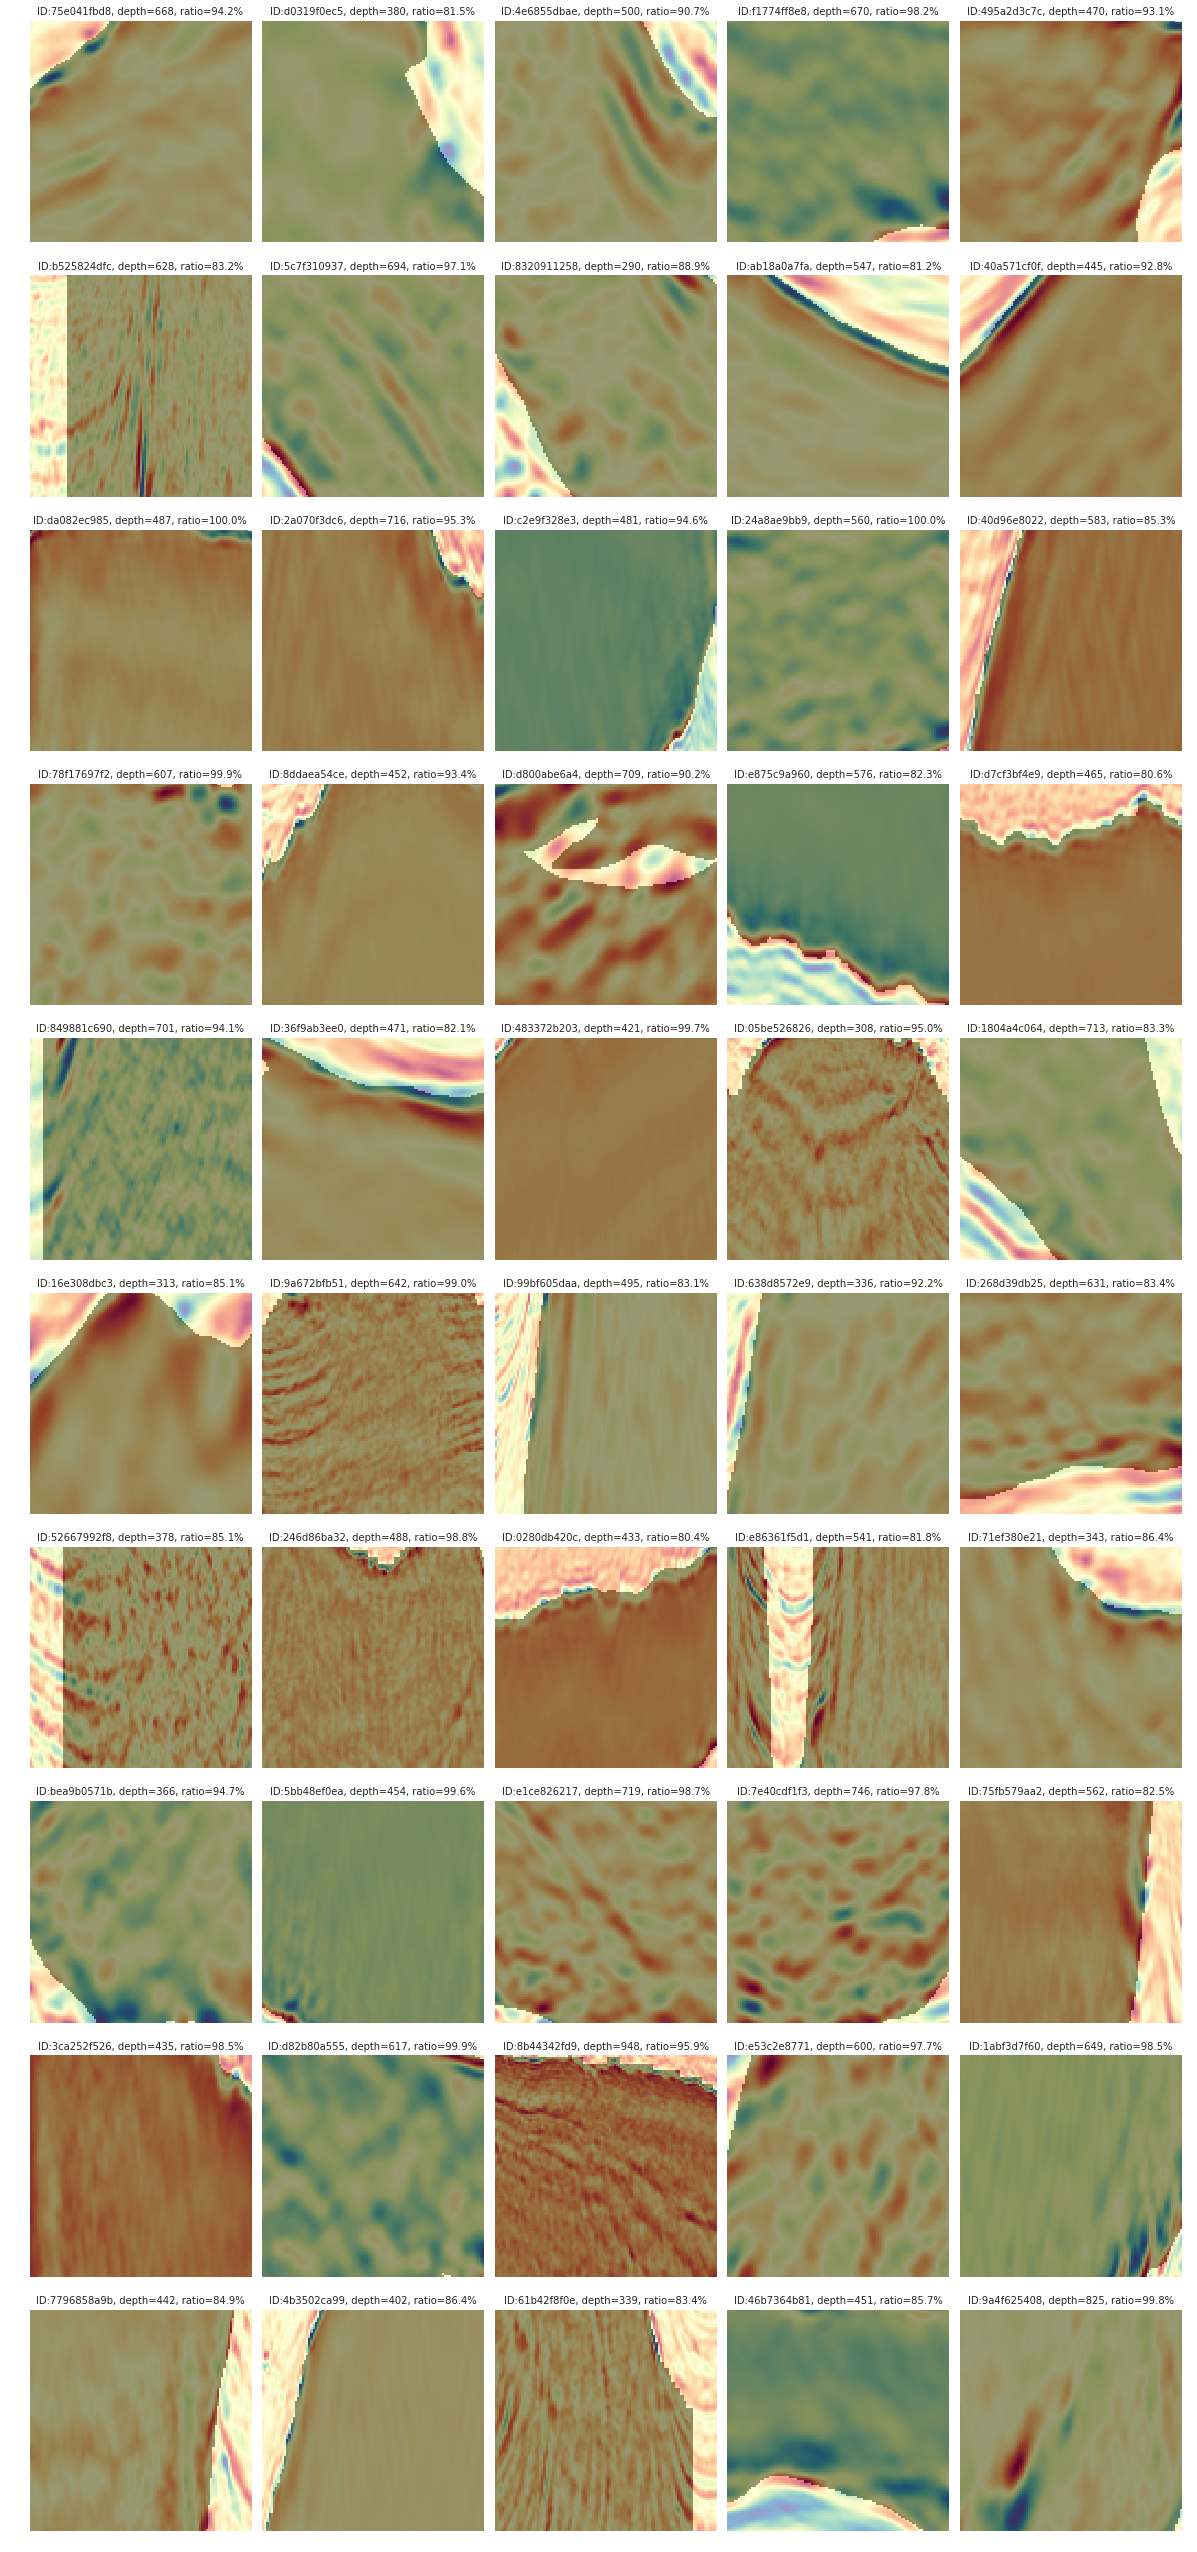

In [18]:
# mask ratio: [0.8, 1)
draw_train_data(train_df.index, start_pos, mask_thresh_lower=0.8, mask_thresh_upper=1)

In [19]:
# total folds numbers for cross-validation
cv_total = 5
#cv_index = 1 -5

# image sizes
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    return img
    
def downsample(img):# not used
    return img

## Calculate the salt coverage and salt coverage classes
This mask type is used for stratify, the difficuly of training different mask type is different.

Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only. Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

* Reference  from Heng's discussion, search "error analysis" in the following link

https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984#382657****

In [20]:
#### Reference  from Heng's discussion
# https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984#382657
def get_mask_type(mask, img_size=img_size_target, border=10):

    outer = np.zeros((img_size-2*border, img_size-2*border), np.float32)
    # original code:
    #outer = cv2.copyMakeBorder(outer, border, border, border, border, borderType = cv2.BORDER_CONSTANT, value = 1)
    # my code (hzh)
    outer = np.pad(outer, pad_width=border, mode='constant', constant_values=1)

    cover = (mask>0.5).sum()
    if cover < 8:
        return 0 # empty
    if cover == ((mask*outer) > 0.5).sum():
        return 1 #border
    if np.all(mask==mask[0]):
        return 2 #vertical

    percentage = cover/(101*101)
    if percentage < 0.15:
        return 3
    elif percentage < 0.25:
        return 4
    elif percentage < 0.50:
        return 5
    elif percentage < 0.75:
        return 6
    else:
        return 7

def histcoverage(coverage):
    histall = np.zeros((1,8))
    for c in coverage:
        histall[0,c] += 1
    return histall

train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_target, 2)

train_df["coverage_class"] = train_df.masks.map(get_mask_type)


## Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also shows an image to check for correct upsampling.

In [21]:
train_all = []
evaluate_all = []

# Stratified K-Folds cross-validator
# Provides train/test indices to split data in train/test sets.
# This cross-validation object is a variation of KFold that returns stratified folds. 
# The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits=cv_total, random_state=1234, shuffle=True)
for train_index, evaluate_index in skf.split(train_df.index.values, train_df.coverage_class):
    train_all.append(train_index)
    evaluate_all.append(evaluate_index)
    print(train_index.shape,evaluate_index.shape) # the shape is slightly different in different cv, it's OK

(3198,) (802,)
(3199,) (801,)
(3199,) (801,)
(3200,) (800,)
(3204,) (796,)


In [22]:
def get_cv_data(cv_index):
    train_index = train_all[cv_index-1]
    evaluate_index = evaluate_all[cv_index-1]
    #
    x_train = np.array(train_df.images[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = np.array(train_df.masks[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    x_valid = np.array(train_df.images[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_valid = np.array(train_df.masks[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    return x_train,y_train,x_valid,y_valid

## Show  some examples of different mask

(3198,) (802,)
train cv1: number of each mask class = 
 	[[1279.  192.   84.  372.  179.  407.  334.  351.]]
evaluate cv1: number of each mask class = 
 	 [[320.  48.  22.  93.  45. 102.  84.  88.]]


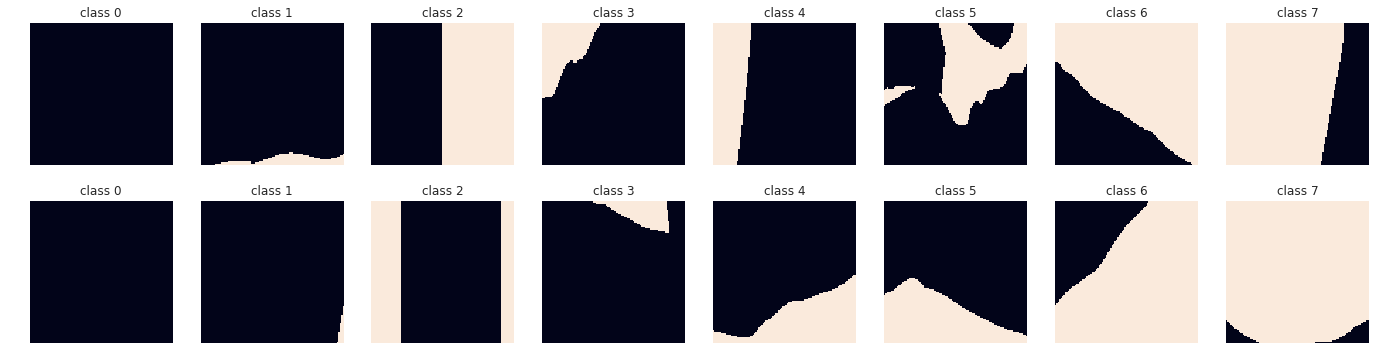

In [23]:
cv_index = 1

# for given fold index, obtain its indices for train/evaluation 
train_index = train_all[cv_index-1]
evaluate_index = evaluate_all[cv_index-1]

print(train_index.shape,evaluate_index.shape)

# for train
histall = histcoverage(train_df.coverage_class[train_index].values)
print(f'train cv{cv_index}: number of each mask class = \n \t{histall}')

# for evaluation
histall_test = histcoverage(train_df.coverage_class[evaluate_index].values)
print(f'evaluate cv{cv_index}: number of each mask class = \n \t {histall_test}')

# show mask class example
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(24, 6), sharex=True, sharey=True)

# masks
for c in range(8):
    j= 0
    for i in train_index:
        if train_df.coverage_class[i] == c:
            axes[j,c].imshow( np.array(train_df.masks[i]) )
            axes[j,c].set_axis_off()
            axes[j,c].set_title(f'class {c}')
            j += 1
            if(j>=2):
                break

## Test
Load, predict, and submit the test image predictions

In [24]:
# load test images
test_df["images"] = [imread(os.path.join(data_dir, "test/images/{}.png".format(idx))) for idx in tqdm_notebook(test_df.index)]

print(f'The number of test images: {len(test_df["images"])}')
print(f'test image shape: {test_df["images"][0].shape}')


The number of test images: 18000
test image shape: (101, 101, 3)


/wg/common/UTILITYSUITE/apps/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


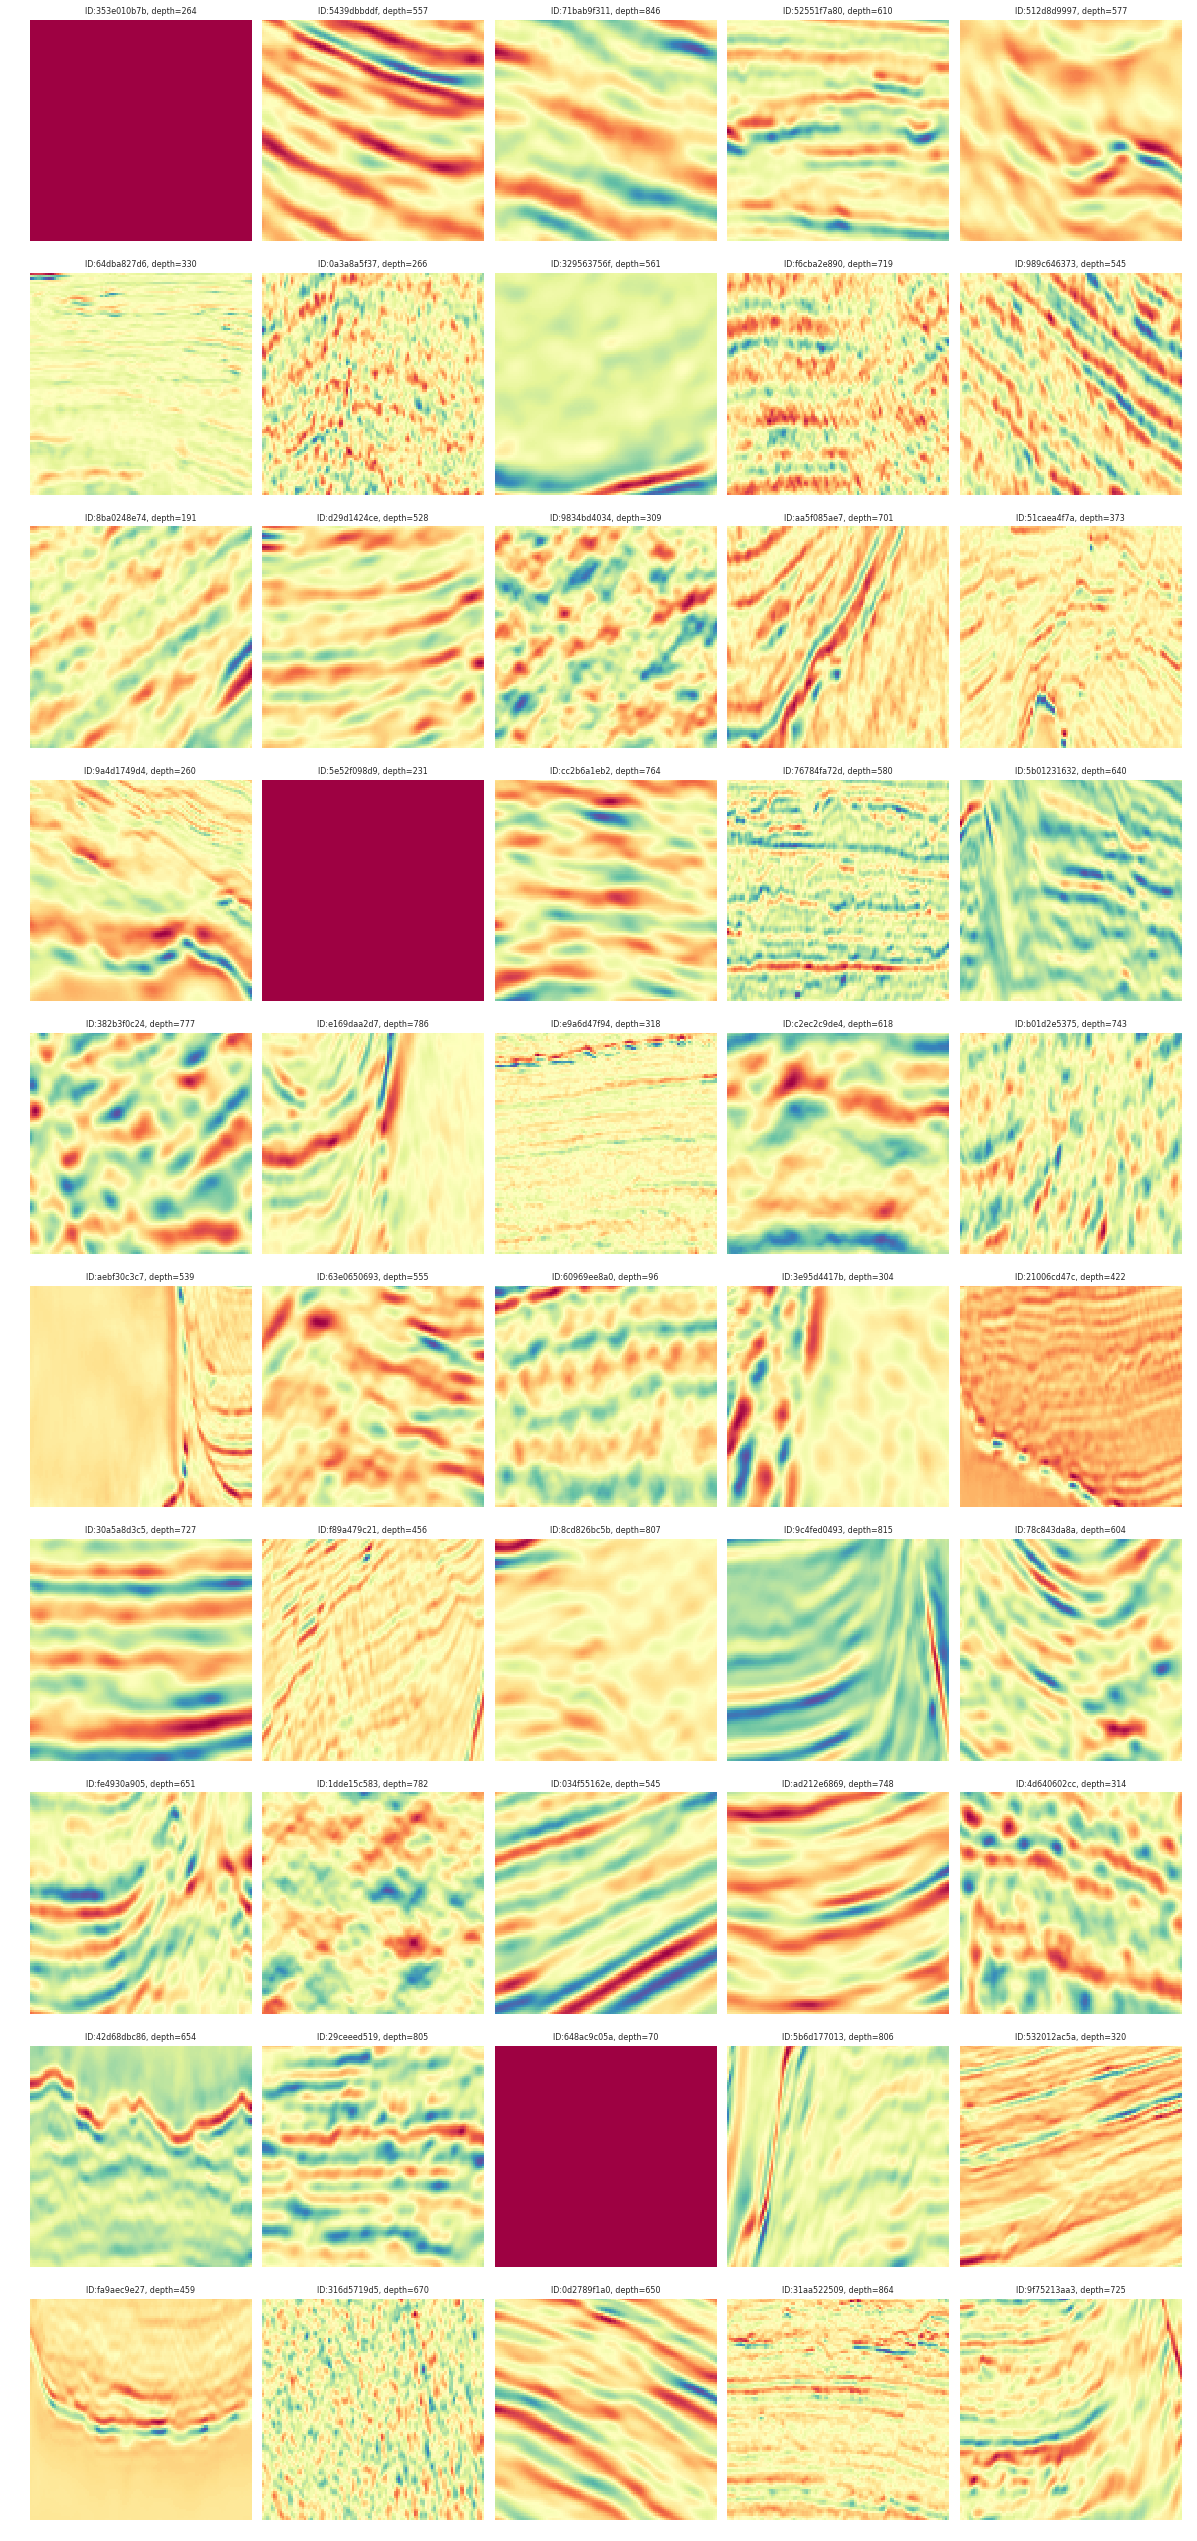

In [25]:
# qc test images
start_pos = 0
#
test_ids = test_df.index[start_pos:]
test_imgs = test_df["images"][start_pos:]

#
n_col = 5
n_row = 10
n_img = n_col * n_row

plt.figure(figsize=(16, 3.5*n_row))

cnt = 0
for i, img_id in enumerate(test_ids):

    # test image
    img = test_imgs[i]

    plt.subplot(n_row, n_col, i+1)
    plt.imshow(img.mean(axis=2), cmap="Spectral")
    #plt.imshow(img[:,:,2], cmap="seismic")

    depth = depths_df.loc[img_id].z
    plt.title(f"ID:{img_id}, depth={depth}", fontsize=8)
    
    plt.grid(False)
    plt.axis('off')
    
    if cnt >= n_img-1:
        break

    cnt += 1
    
plt.subplots_adjust(top=1.0, bottom=0.0, 
                    left=0.0, right=1.0, 
                    hspace=0.05, wspace=0.05)



x_test = np.array([(np.array(load_img(os.path.join(data_dir, "test/images/{}.png".format(idx)), color_mode='grayscale'))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)


# average the predictions from different folds
t1 = time.time()
preds_test = np.zeros(np.squeeze(x_test).shape)
for cv_index in range(cv_total):
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    model.load_weights(basic_name + '.model')
    preds_test += predict_result(model,x_test,img_size_target) /cv_total
    
t2 = time.time()
print(f"Usedtime = {t2-t1} s")

"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


t1 = time.time()
threshold  = 0.5 # some value in range 0.4- 0.5 may be better 
pred_dict = {idx: rle_encode(np.round(preds_test[i]) > threshold) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")